# Test alternatives to Neural Networks

In [1]:
# import the relevant packages
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
tf.keras.backend.set_floatx('float64')
from tensorflow import keras
from tensorflow.keras import layers

from helper_functions.scan_helper_functions import train_forward_model, load_dataset, build_forward_surrogate, calculate_metrics
from helper_functions.scan_helper_functions import calculate_metrics

import sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.multioutput import RegressorChain
from sklearn.svm import LinearSVR
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

# Load and prepare data

In [2]:
directory = os.path.dirname(os.path.dirname(os.getcwd()))

In [3]:
# load the data and split it into training, validation, test data
datafile = directory +'/aerosol_data/phase_data.hdf5'
dvar_train, dvar_val, dvar_test, qoi_train, qoi_val, qoi_test = load_dataset(datafile)

In [4]:
dvar_columns = dvar_test.columns
qoi_columns = qoi_test.columns

dvar_train_df = pd.DataFrame(dvar_train, columns = dvar_columns)
dvar_val_df = pd.DataFrame(dvar_val,columns = dvar_columns)
dvar_test_df = dvar_test.copy()
qoi_train_df = pd.DataFrame(qoi_train, columns = qoi_columns)
qoi_val_df = pd.DataFrame(qoi_val, columns = qoi_columns)
qoi_test_df = qoi_test.copy()

In [5]:
dvar_test.reset_index(drop=True, inplace=True)
qoi_test.reset_index(drop=True,inplace=True)
indices = qoi_test.index
qoi_test = qoi_test.values[indices]
indices = dvar_test.index
dvar_test = dvar_test.values[indices]

In [6]:
# Scale the data to the interval [0,1]
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
dvar_test_n = min_max_scaler.fit_transform(dvar_test)
qoi_test_n = min_max_scaler.fit_transform(qoi_test)
dvar_val_n = min_max_scaler.fit_transform(dvar_val)
qoi_val_n = min_max_scaler.fit_transform(qoi_val)
dvar_train_n = min_max_scaler.fit_transform(dvar_train)
qoi_train_n = min_max_scaler.fit_transform(qoi_train)

In [7]:
dvar_train_big_n = np.concatenate((dvar_train_n,dvar_val_n),axis=0)
qoi_train_big_n = np.concatenate((qoi_train_n,qoi_val_n),axis=0)


In [8]:
print(dvar_train_n.shape)
print(dvar_val_n.shape)
print(dvar_train_big_n.shape)
print(dvar_test_n.shape)
print(qoi_train_n.shape)
print(qoi_val_n.shape)
print(qoi_train_big_n.shape)
print(qoi_test_n.shape)

(25344, 5)
(6336, 5)
(31680, 5)
(7920, 5)
(25344, 180)
(6336, 180)
(31680, 180)
(7920, 180)


In [9]:
# create some data to test the linear regression
test_methods_x, test_methods_y = make_regression(n_samples=1000, n_features=10, n_informative=5,n_targets=2,random_state=1,noise=0.5)
print(test_methods_x.shape)
print(test_methods_y.shape)
test_methods_x_train,test_methods_x_test, test_methods_y_train, test_methods_y_test=train_test_split(test_methods_x,test_methods_y, test_size=0.33,random_state=42)

(1000, 10)
(1000, 2)


# Linear Regression for Multioutput Regression
## Test the linear regression with the test example

In [10]:
model_linear_test = LinearRegression()

In [11]:
model_linear_test.fit(test_methods_x_train,test_methods_y_train)

LinearRegression()

In [12]:
test_methods_y_pred = model_linear_test.predict(test_methods_x_test)

In [13]:
print(test_methods_y_pred.shape)
len(test_methods_y_pred[0])

(330, 2)


2

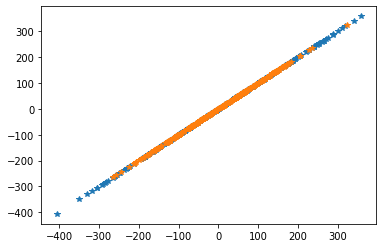

In [14]:
plt.plot(test_methods_y_pred[:],test_methods_y_test[:],'*')

In [15]:
for i in [0,1,2,3,4,5]:
    plt.plot(np.arange(0,len(test_methods_y_pred[i])),test_methods_y_pred[i],'r*')
    plt.plot(np.arange(0,len(test_methods_y_test[i])),test_methods_y_test[i],'b*')

## Linear regression for aerosol data

In [16]:
model_linear = LinearRegression()

In [17]:
model_linear.fit(dvar_train_big_n,qoi_train_big_n)

LinearRegression()

In [18]:
qoi_pred_linear_n = model_linear.predict(dvar_test_n)

In [19]:
print(qoi_pred_linear_n.shape)
print(qoi_test_n.shape)

(7920, 180)
(7920, 180)


In [20]:
n_in = dvar_test.shape[1]
metrics_test_linear = calculate_metrics(qoi_pred_linear_n, qoi_test_n, n_in)
metrics_test_linear

{'MAE': 0.09220559055831411,
 'MAPE': 16.94510622936996,
 'median_percentile_max_error': 23.320738798083184,
 '90_percentile_max_error': 53.997923559321826,
 'r2': 0.49665965344222324,
 'r2_adj': 0.49634164715806994}

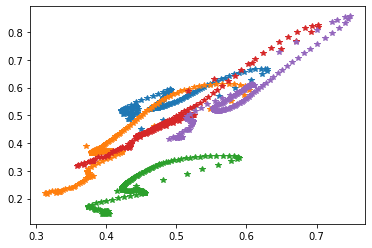

In [21]:
for i in range(5):
    plt.plot(qoi_pred_linear_n[i], qoi_test_n[i],'*')
    

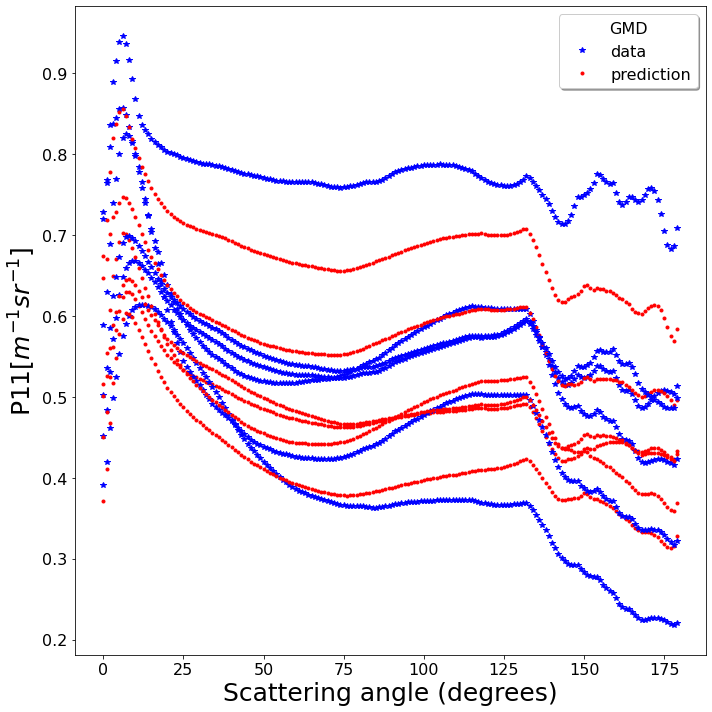

In [22]:
presentation_plot_index = [0,1,3,4,5,6]
fig, ax = plt.subplots(figsize = (10,10))
for index in presentation_plot_index:
    ax.plot(np.arange(0,len(qoi_test_n[0])),qoi_test_n[index],'b*')
    ax.plot(np.arange(0,len(qoi_pred_linear_n[0])),qoi_pred_linear_n[index],'r.')
    
    #plt.yscale('logit')

ax.set_xlabel('Scattering angle (degrees)',fontsize = 25)
ax.set_ylabel('P11[$m^{-1}sr^{-1}$]',fontsize = 25)
ax.tick_params(labelsize = 16)    
fig.tight_layout() 
#ax.set_title('GSD=1.5, RI_n=1.5, RI_k=0.005',fontsize = 25)
#fig.align_labels()
ax.legend(['data','prediction'],loc='upper right', shadow=True,title='GMD', fontsize=16)
ax.get_legend().get_title().set_fontsize('16')
#fig.savefig(f'{plot_dir}/phase_data__result.jpg')

# Decision Tree for Multioutput Regression

In [24]:
model_decision_tree = DecisionTreeRegressor()
model_decision_tree.fit(dvar_train_big_n,qoi_train_big_n)

DecisionTreeRegressor()

In [25]:
qoi_pred_decision_tree_n = model_decision_tree.predict(dvar_test_n)

In [26]:
print(qoi_pred_decision_tree_n.shape)
print(qoi_test_n.shape)

(7920, 180)
(7920, 180)


In [37]:
n_in = dvar_test_n.shape[1]
metrics_test_decision_tree = calculate_metrics(qoi_pred_decision_tree_n, qoi_test_n, n_in)
metrics_test_decision_tree

/psi/home/boiger_r/.local/lib/python3.7/site-packages/helper_functions/scan_helper_functions.py:83: RuntimeWarning: divide by zero encountered in true_divide
  rel_residuals = np.abs(abs_residuals / qoi_true) * 100.
/psi/home/boiger_r/.local/lib/python3.7/site-packages/helper_functions/scan_helper_functions.py:83: RuntimeWarning: invalid value encountered in true_divide
  rel_residuals = np.abs(abs_residuals / qoi_true) * 100.


{'MAE': 0.006578032988520181,
 'MAPE': nan,
 'median_percentile_max_error': nan,
 '90_percentile_max_error': nan,
 'r2': 0.9981902521377197,
 'r2_adj': 0.9981891087539301}

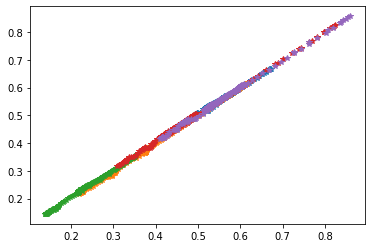

In [28]:
for i in range(5):
    plt.plot(qoi_pred_decision_tree_n[i], qoi_test_n[i],'*')

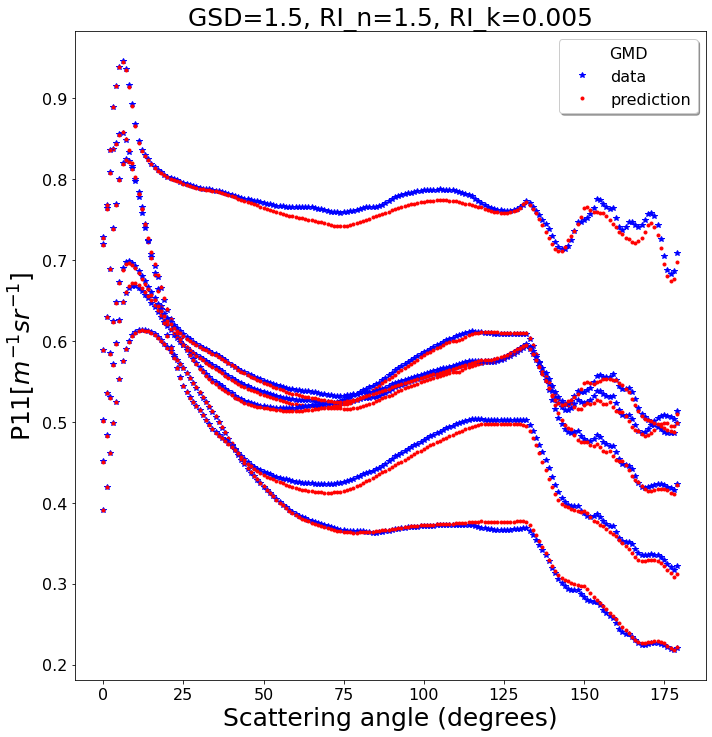

In [29]:
presentation_plot_index = [0,1,3,4,5,6]
fig, ax = plt.subplots(figsize = (10,10))
for index in presentation_plot_index:
    ax.plot(np.arange(0,len(qoi_test_n[0])),qoi_test_n[index],'b*')
    ax.plot(np.arange(0,len(qoi_pred_decision_tree_n[0])),qoi_pred_decision_tree_n[index],'r.')
    
    #plt.yscale('logit')

ax.set_xlabel('Scattering angle (degrees)',fontsize = 25)
ax.set_ylabel('P11[$m^{-1}sr^{-1}$]',fontsize = 25)
ax.tick_params(labelsize = 16)    
fig.tight_layout() 
ax.set_title('GSD=1.5, RI_n=1.5, RI_k=0.005',fontsize = 25)
#fig.align_labels()
ax.legend(['data','prediction'],loc='upper right', shadow=True,title='GMD', fontsize=16)
ax.get_legend().get_title().set_fontsize('16')
#fig.savefig(f'{plot_dir}/phase_data__result.jpg')

# k-Nearest Neighbors for Multioutput Regression

https://machinelearningmastery.com/multi-output-regression-models-with-python/

In [23]:
from sklearn.neighbors import KNeighborsRegressor

In [31]:
model_kneighbor = KNeighborsRegressor()

In [32]:
model_kneighbor.fit(dvar_train_big_n,qoi_train_big_n)

KNeighborsRegressor()

In [33]:
qoi_pred_kneighbor_n = model_kneighbor.predict(dvar_test_n)

In [35]:
print(qoi_pred_kneighbor_n.shape)
print(qoi_test_n.shape)

(7920, 180)
(7920, 180)


In [36]:
n_in = dvar_test_n.shape[1]
metrics_test_kneighbor = calculate_metrics(qoi_pred_kneighbor_n, qoi_test_n, n_in)
metrics_test_kneighbor

{'MAE': 0.01989251600819964,
 'MAPE': 3.76242113374795,
 'median_percentile_max_error': 5.248857954982913,
 '90_percentile_max_error': 13.267410566476626,
 'r2': 0.9760956380025391,
 'r2_adj': 0.9760805354235667}

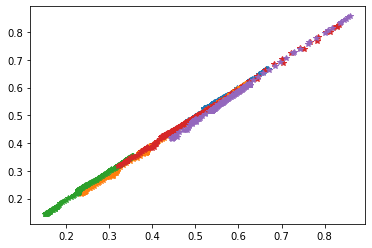

In [38]:
for i in range(5):
    plt.plot(qoi_pred_kneighbor_n[i], qoi_test_n[i],'*')

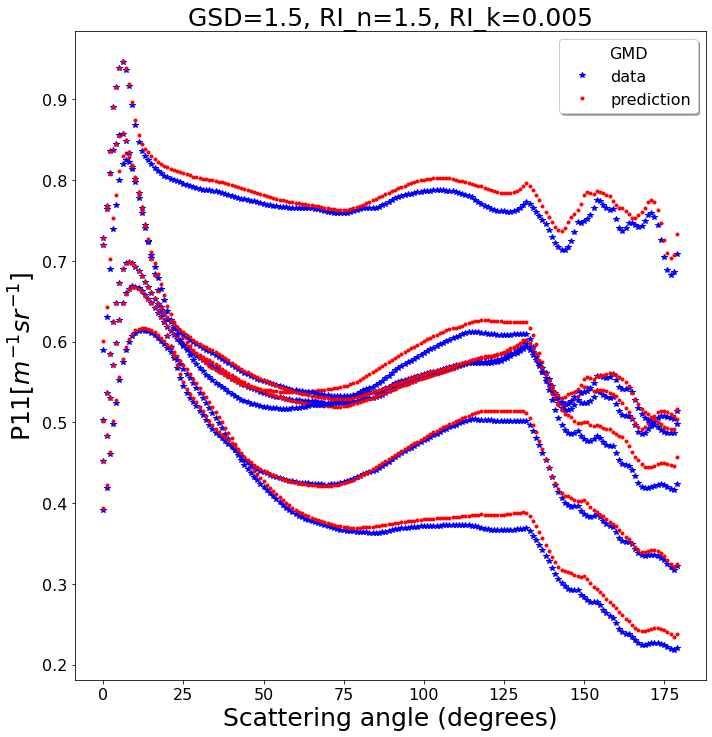

In [39]:
presentation_plot_index = [0,1,3,4,5,6]
fig, ax = plt.subplots(figsize = (10,10))
for index in presentation_plot_index:
    ax.plot(np.arange(0,len(qoi_test_n[0])),qoi_test_n[index],'b*')
    ax.plot(np.arange(0,len(qoi_pred_kneighbor_n[0])),qoi_pred_kneighbor_n[index],'r.')
    
    #plt.yscale('logit')

ax.set_xlabel('Scattering angle (degrees)',fontsize = 25)
ax.set_ylabel('P11[$m^{-1}sr^{-1}$]',fontsize = 25)
ax.tick_params(labelsize = 16)    
fig.tight_layout() 
ax.set_title('GSD=1.5, RI_n=1.5, RI_k=0.005',fontsize = 25)
#fig.align_labels()
ax.legend(['data','prediction'],loc='upper right', shadow=True,title='GMD', fontsize=16)
ax.get_legend().get_title().set_fontsize('16')
#fig.savefig(f'{plot_dir}/phase_data__result.jpg')

# Support Vector Regression 

In [44]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor

from sklearn.svm import SVR

svr_1 = SVR()
model_svr = MultiOutputRegressor(svr_1)



In [45]:
model_svr.fit(dvar_train_big_n,qoi_train_big_n)


MultiOutputRegressor(estimator=SVR())

In [46]:
qoi_pred_svr_n = model_svr.predict(dvar_test_n)

In [47]:
print(qoi_pred_svr_n.shape)
print(qoi_test_n.shape)

(7920, 180)
(7920, 180)


In [48]:
n_in = dvar_test_n.shape[1]
metrics_test_kneighbor = calculate_metrics(qoi_pred_svr_n, qoi_test_n, n_in)
metrics_test_kneighbor

{'MAE': 0.04903626121074448,
 'MAPE': 11.333631253274447,
 'median_percentile_max_error': 14.028913678985369,
 '90_percentile_max_error': 36.291882995415634,
 'r2': 0.908525236269096,
 'r2_adj': 0.9084674432669916}

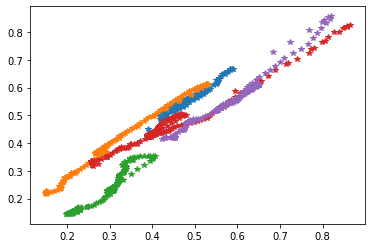

In [49]:
for i in range(5):
    plt.plot(qoi_pred_svr_n[i], qoi_test_n[i],'*')
    

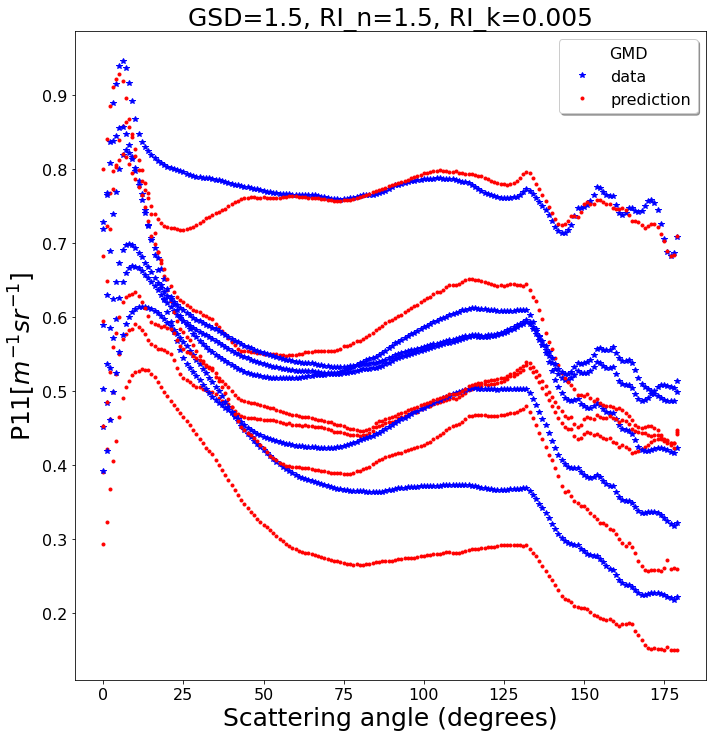

In [50]:
presentation_plot_index = [0,1,3,4,5,6]
fig, ax = plt.subplots(figsize = (10,10))
for index in presentation_plot_index:
    ax.plot(np.arange(0,len(qoi_test_n[0])),qoi_test_n[index],'b*')
    ax.plot(np.arange(0,len(qoi_pred_svr_n[0])),qoi_pred_svr_n[index],'r.')
    
    #plt.yscale('logit')

ax.set_xlabel('Scattering angle (degrees)',fontsize = 25)
ax.set_ylabel('P11[$m^{-1}sr^{-1}$]',fontsize = 25)
ax.tick_params(labelsize = 16)    
fig.tight_layout() 
ax.set_title('GSD=1.5, RI_n=1.5, RI_k=0.005',fontsize = 25)
#fig.align_labels()
ax.legend(['data','prediction'],loc='upper right', shadow=True,title='GMD', fontsize=16)
ax.get_legend().get_title().set_fontsize('16')
#fig.savefig(f'{plot_dir}/phase_data__result.jpg')

# PCA https://nirpyresearch.com/principal-component-regression-python/